# Introduction

Some of the benchmark results on MNIST include can be found on Yann LeCun's page and include:

88% Lecun et al., 1998 95.3% Lecun et al., 1998 99.65% Ciresan et al., 2011

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

# Importing Essential Libraries

In [1]:
import torch
print(torch.__version__)

2.3.0+cpu


In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

# Libraries for Data Visualization and Manipulation

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
from sklearn.metrics import confusion_matrix

In [4]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


# Load Dataset

Specify your transforms as a list if you intend to. The transforms module is already loaded as transforms.

MNIST is fortunately included the torchvision module. Then, we can create datasets using the MNIST object from torchvision.datasets. Make sure to specify download=True !

Once dataset is created, we'll also need to define Dataloader from torch.utils.data module for both train and test data.

In [5]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

# Loading Dataset
mnist_dataset=torchvision.datasets.MNIST(root="data", train=True, download=True, transform=transform)

# Defining the sizes of train, validation, test sets
train_size = int(0.6*len(mnist_dataset))
val_size = int(0.2*len(mnist_dataset))
test_size=len(mnist_dataset)-train_size-val_size

#Splitting the MNIST dataset
train_dataset, val_dataset, test_dataset=random_split(mnist_dataset,[train_size,val_size,test_size])

#Create test set and define test dataloader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)

# Justifying Preprocess

The only preprocessing is "Normalization" to convert the graysclae values to tensors with numbers between 0 and 1. The image size in this data set seems perfect -28*28- and we will not need to rotate images or flip them since we will predict images which are always in the right rotation


# Explore the Dataset

Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the show5 function defined below – it takes a data loader as an argument. Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images. Typically using no transforms other than toTensor() works well for viewing – but not as well for training your network. If show5 doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [6]:
def show5(img_loader):
    dataiter=iter(img_loader)

    batch=next(dataiter)
    labels=batch[1][0:5]
    images=batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))

        image=images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

0


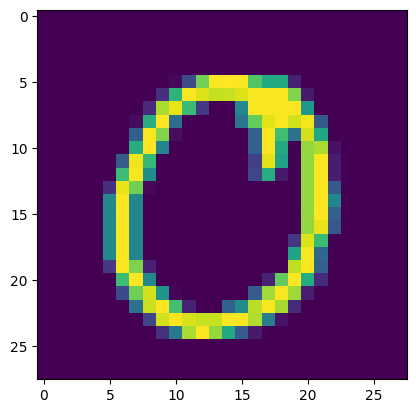

3


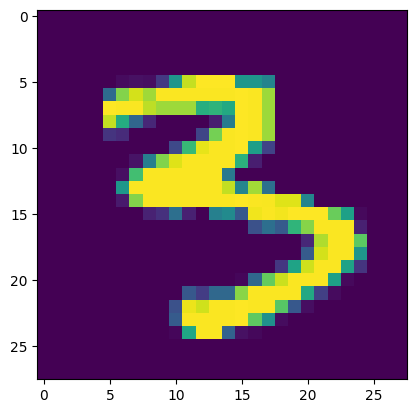

4


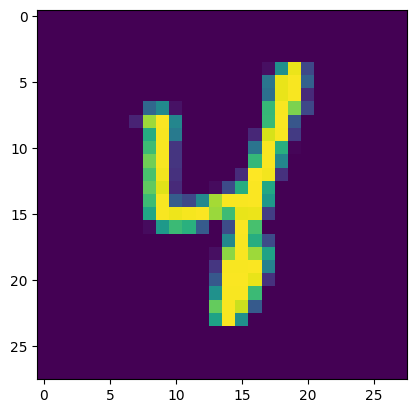

3


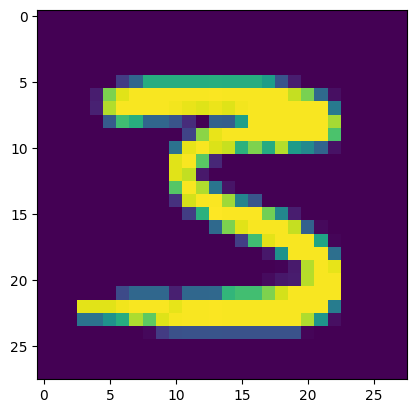

1


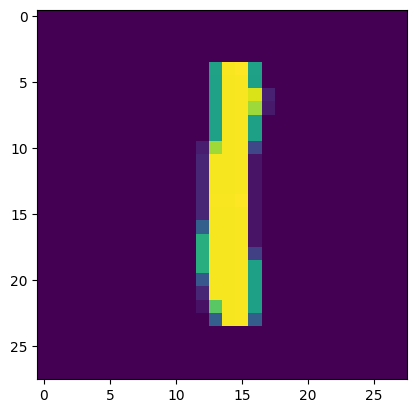

In [7]:
show5(train_loader)

# Building Neural Net

Using torch.nn (which has been imported as nn) and the torch.nn.functional module (imported as F), construct a neural network based on the parameters of the dataset.

Note: If you don't flatten tensors in transforms or as part of your preprocessing and you are using only Linear layers, make sure to use the Flatten layer in Neural Net.

In [8]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation=F.relu
        self.layer1 = nn.Linear(28 * 28 * 1, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, 10)

    def forward(self,x):
        x=torch.flatten(x,1)
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.activation(self.layer3(x))
        x = self.layer4(x)
        x = F.softmax(x, dim=1)
        return x

Setting a loss function and an optimizer, and instantiate the model.

In [9]:
net = Net()

optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.99, weight_decay=0.001)
criterion = nn.CrossEntropyLoss()

# Running Neural Network

If we've available to use GPU then we can use torch.device() and .to() method for model and data.
IF we want to print loss during each epoch, we can use enumerate function and print the loss after a set number of batches. 250 batches works well for most people.

In [10]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)

Net(
  (layer1): Linear(in_features=784, out_features=256, bias=True)
  (layer2): Linear(in_features=256, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=64, bias=True)
  (layer4): Linear(in_features=64, out_features=10, bias=True)
)

In [11]:
num_epochs=20

train_loss_history=[]
val_loss_history=[]

for epoch in range(num_epochs):
    net.train()

    train_loss=0.0
    train_correct=0
    total_predictions=0

    for i,data in enumerate(train_loader):
        inputs,labels=data

        if torch.cuda.is_available():
            inputs,labels=inputs.to(device),labels.to(device)

        optimizer.zero_grad()
        outputs=net(inputs)
        loss=criterion(outputs,labels)

        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()

    print(f"Epoch {epoch + 1} training accuracy: {train_correct/total_predictions * 100:.2f}% training loss: {train_loss/len(train_loader):.5f}")
    train_loss_history.append(train_loss/len(train_loader))

    val_loss = 0.0
    val_correct = 0
    total_predictions = 0
    net.eval()
    for inputs, labels in val_loader:
        if torch.cuda.is_available():
            inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        _, preds = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        val_correct += (preds == labels).sum().item()
        val_loss += loss.item()
    print(f"Epoch {epoch + 1} validation accuracy: {val_correct/total_predictions * 100:.2f}% validation loss: {val_loss/len(val_loader):.5f}")
    val_loss_history.append(val_loss/len(val_loader))

Epoch 1 training accuracy: 33.36% training loss: 2.10633
Epoch 1 validation accuracy: 62.18% validation loss: 1.83899
Epoch 2 training accuracy: 62.96% training loss: 1.83005
Epoch 2 validation accuracy: 64.76% validation loss: 1.81276
Epoch 3 training accuracy: 66.02% training loss: 1.79925
Epoch 3 validation accuracy: 65.97% validation loss: 1.80039
Epoch 4 training accuracy: 74.18% training loss: 1.72050
Epoch 4 validation accuracy: 81.17% validation loss: 1.65060
Epoch 5 training accuracy: 82.84% training loss: 1.63380
Epoch 5 validation accuracy: 82.50% validation loss: 1.63617
Epoch 6 training accuracy: 85.54% training loss: 1.60842
Epoch 6 validation accuracy: 88.57% validation loss: 1.57838
Epoch 7 training accuracy: 89.76% training loss: 1.56564
Epoch 7 validation accuracy: 91.35% validation loss: 1.55072
Epoch 8 training accuracy: 91.65% training loss: 1.54878
Epoch 8 validation accuracy: 89.97% validation loss: 1.56589
Epoch 9 training accuracy: 91.63% training loss: 1.54747

# Training Loss and Validation Loss Visualization

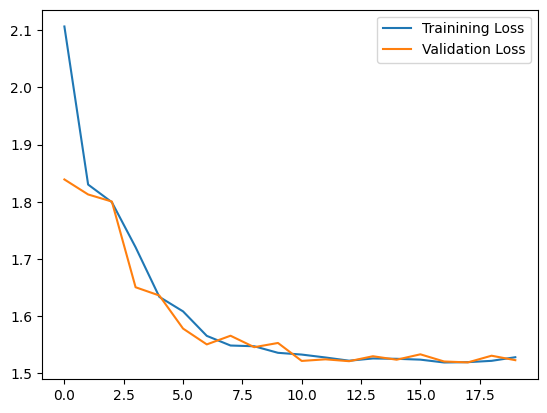

In [13]:
plt.plot(train_loss_history,label="Trainining Loss")
plt.plot(val_loss_history,label="Validation Loss")
plt.legend()
plt.show()

# Testing Model

In [15]:
correct_predictions=0
total_predictions=0

for inputs,labels in test_loader:
    if torch.cuda.is_available():
        inputs, labels = inputs.to(device), labels.to(device)

    outputs=net(inputs)
    _,preds=torch.max(outputs.data,1)
    total_predictions +=labels.size(0)
    correct_predictions += (preds == labels).sum().item()
    accuracy = (correct_predictions / total_predictions) * 100
    
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 94.21%


# Improving Model Performance

Once model is done training, trying tweaking hyperparameters and training again below to improve your accuracy on the test set!

For improving the model, I'm using Adam Optimizer Algorithm for Experimenting.I decreased the learning rate from 0.01 to 0.001. The first training phase was for finding the right weights and taking huge steps to find them. The second one - the one in the coming code cells - is to take smaller steps to fine-tune the model and get a better accuracy

In [16]:
optimizer=optim.Adam(net.parameters(),lr=0.001, weight_decay=0.001)

In [17]:
num_epochs=20

train_loss_history=[]
val_loss_history=[]

for epoch in range(num_epochs):
    net.train()

    train_loss=0.0
    train_correct=0
    total_predictions=0

    for i,data in enumerate(train_loader):
        inputs,labels=data

        if torch.cuda.is_available():
            inputs,labels=inputs.to(device),labels.to(device)

        optimizer.zero_grad()
        outputs=net(inputs)
        loss=criterion(outputs,labels)

        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()

    print(f"Epoch {epoch + 1} training accuracy: {train_correct/total_predictions * 100:.2f}% training loss: {train_loss/len(train_loader):.5f}")
    train_loss_history.append(train_loss/len(train_loader))

    val_loss = 0.0
    val_correct = 0
    total_predictions = 0
    net.eval()
    for inputs, labels in val_loader:
        if torch.cuda.is_available():
            inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        _, preds = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        val_correct += (preds == labels).sum().item()
        val_loss += loss.item()
    print(f"Epoch {epoch + 1} validation accuracy: {val_correct/total_predictions * 100:.2f}% validation loss: {val_loss/len(val_loader):.5f}")
    val_loss_history.append(val_loss/len(val_loader))

Epoch 1 training accuracy: 95.58% training loss: 1.51001
Epoch 1 validation accuracy: 95.43% validation loss: 1.51227
Epoch 2 training accuracy: 96.08% training loss: 1.50616
Epoch 2 validation accuracy: 95.61% validation loss: 1.51189
Epoch 3 training accuracy: 96.38% training loss: 1.50361
Epoch 3 validation accuracy: 95.98% validation loss: 1.50678
Epoch 4 training accuracy: 96.28% training loss: 1.50493
Epoch 4 validation accuracy: 95.25% validation loss: 1.51397
Epoch 5 training accuracy: 96.39% training loss: 1.50339
Epoch 5 validation accuracy: 96.12% validation loss: 1.50625
Epoch 6 training accuracy: 96.72% training loss: 1.50054
Epoch 6 validation accuracy: 96.16% validation loss: 1.50496
Epoch 7 training accuracy: 96.71% training loss: 1.50103
Epoch 7 validation accuracy: 95.91% validation loss: 1.50718
Epoch 8 training accuracy: 96.71% training loss: 1.50076
Epoch 8 validation accuracy: 96.21% validation loss: 1.50444
Epoch 9 training accuracy: 96.91% training loss: 1.49888

# Final accuracy after tweaking the model

In [18]:
correct_predictions = 0
total_predictions = 0

for inputs, labels in test_loader:
    if torch.cuda.is_available():
        inputs, labels = inputs.to(device), labels.to(device)
        
    outputs = net(inputs)
    _, preds = torch.max(outputs.data, 1)
    total_predictions += labels.size(0)
    correct_predictions += (preds == labels).sum().item()
    accuracy = (correct_predictions / total_predictions) * 100
    
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 96.32%


# Saving the model

In [19]:
torch.save(net.state_dict(), "Digit-Classifier.pth")

# Implementing Sanity Checking 

This part was implemented later. So, to avoid training the model again, we will load the the already trained checkpoint right away

In [20]:
net=Net()

model_path="Digit-Classifier.pth"
checkpoint=torch.load(model_path)

if 'model_state_dict' in checkpoint:
    net.load_state_dict(checkpoint['model_state_dict'])
    print("Model loaded Successfully")

else:
    net.load_state_dict(checkpoint)
    print("Model loaded successfully (full state dictionary).")

if 'optimizer_state_dict' in checkpoint:
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

if epoch in checkpoint:
    epoch=checkpoint=['epoch']

# Move the model to the appropriate device (CPU or GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
net.eval()

Model loaded successfully (full state dictionary).


Net(
  (layer1): Linear(in_features=784, out_features=256, bias=True)
  (layer2): Linear(in_features=256, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=64, bias=True)
  (layer4): Linear(in_features=64, out_features=10, bias=True)
)

# Visualizing Actual Digit vs Predicted Digit

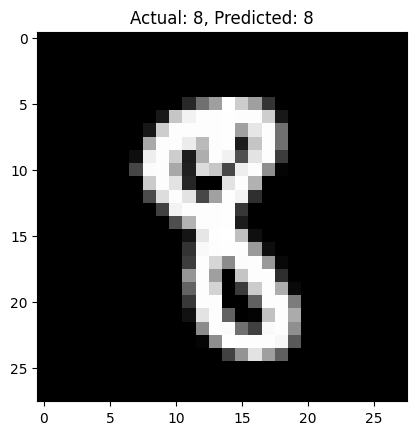

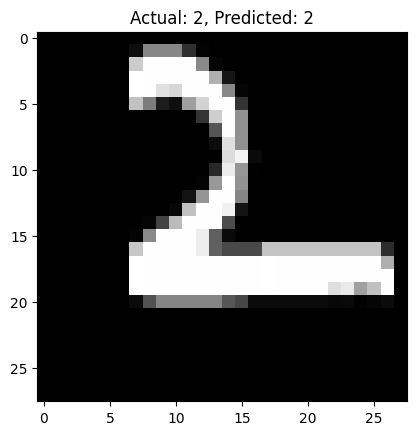

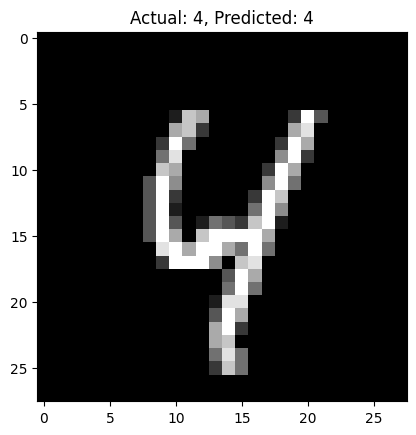

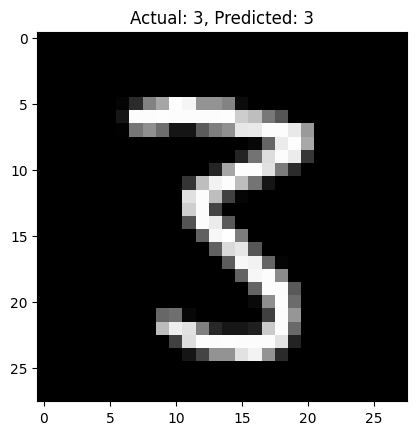

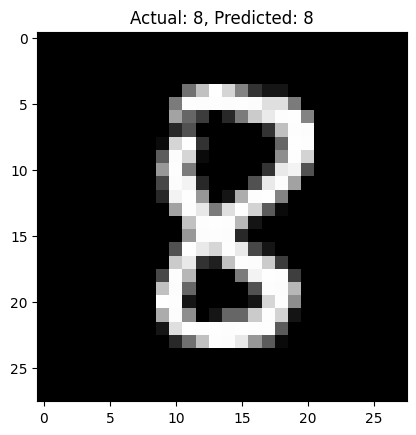

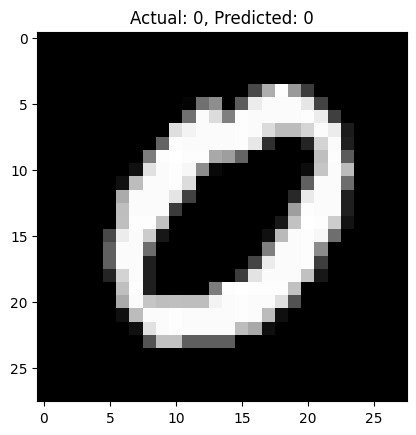

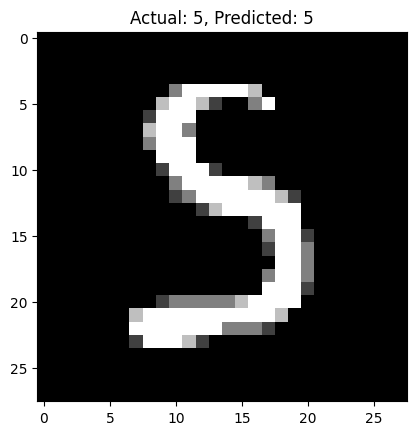

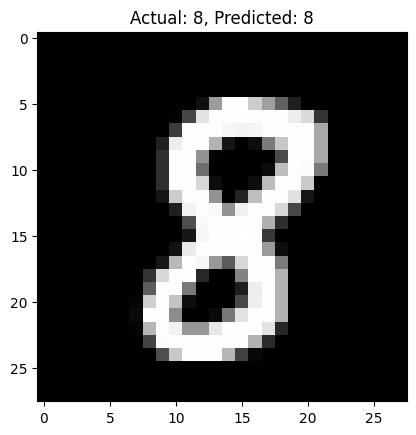

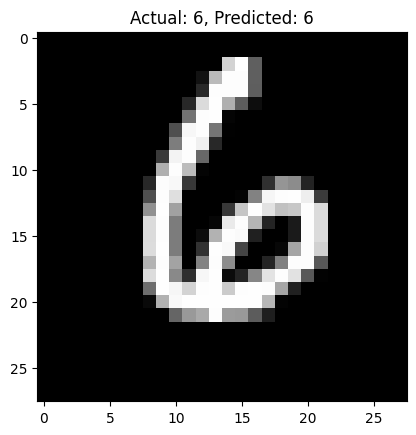

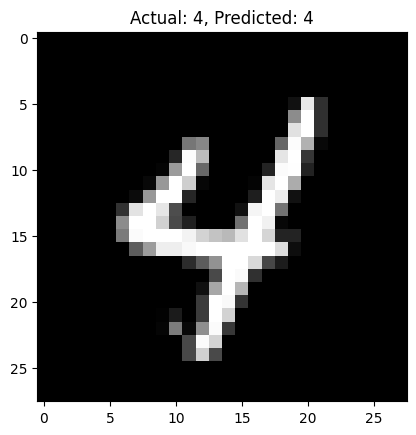

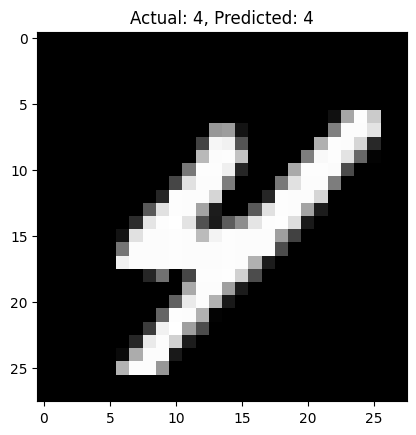

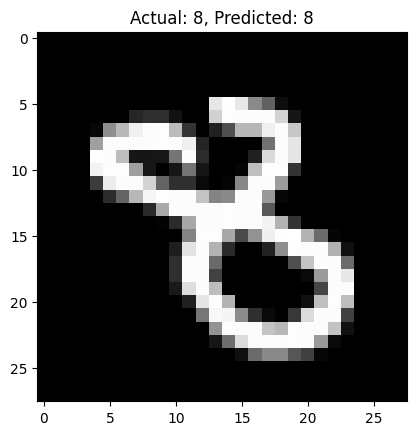

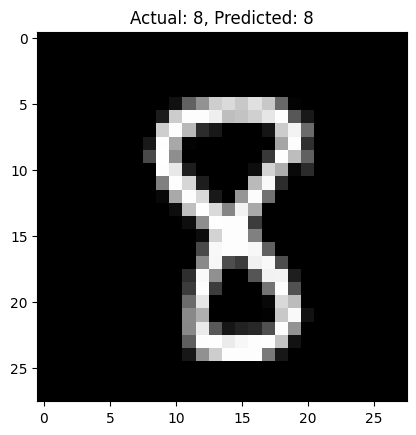

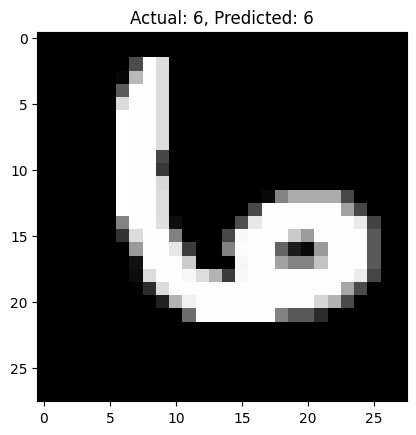

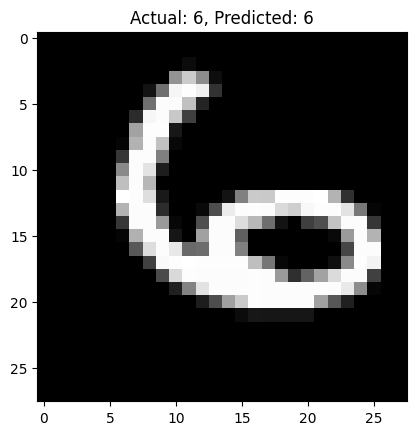

In [21]:
def visualize_results(model, dataloader, device):
    model.eval()

    # Get the total number of samples in the dataset
    total_samples = len(dataloader.dataset)

    # Randomly select 15 indices
    random_indices = random.sample(range(total_samples), 15)

    with torch.no_grad():
        for idx in random_indices:
            inputs, labels = dataloader.dataset[idx]
            inputs, labels = inputs.unsqueeze(0).to(device), torch.tensor([labels]).to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Convert tensors to NumPy arrays
            inputs = inputs.cpu().numpy()
            labels = labels.cpu().numpy()
            preds = preds.cpu().numpy()

            # Display the sample
            plt.imshow(np.squeeze(inputs), cmap='gray')
            plt.title(f"Actual: {labels.item()}, Predicted: {preds[0]}")
            plt.show()

# Call the function with the model and the test dataloader
visualize_results(net, test_loader, device)

# Confusion Matrix


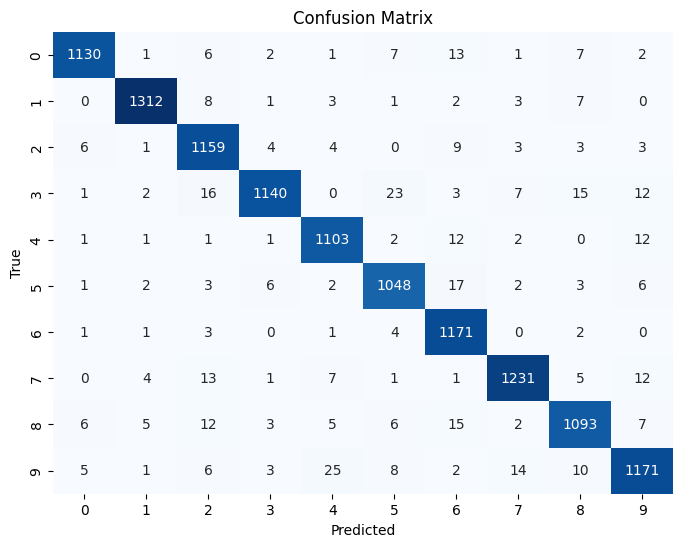

In [23]:
all_preds=[]
all_labels=[]

for inputs, labels in test_loader:
    if torch.cuda.is_available():
        inputs, labels = inputs.to(device), labels.to(device)
        
    outputs = net(inputs)
    _, preds = torch.max(outputs.data, 1)
    
    total_predictions += labels.size(0)
    correct_predictions += (preds == labels).sum().item()
    
    # Append predictions and labels for confusion matrix
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

# Create a confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()